In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import ee
import geemap
# 导入相关库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# 加载研究区域
roi = ee.FeatureCollection('users/311605001111/YangtzeCity/wuhan').geometry()
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,9)

# 加载样本集
samples = ee.FeatureCollection('users/311605001111/wuhan_2018')
# Map.addLayer(samples, {}, "WuhanTrainingPoints_2020")
print(samples.size().getInfo())

# #各类的个数
# clt_water = samples.filter(ee.Filter.eq('waterclass',0))
# print(clt_water.size().getInfo())
# clt_nowater = samples.filter(ee.Filter.eq('waterclass',1))
# print(clt_nowater.size().getInfo())

2154


In [4]:
## 加载影像

# 去云、云阴影、雪掩膜函数
def maskL8sr(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    return image.updateMask(mask)
# landsat影像可视化参数
visParams = {
    'bands': ['B5', 'B6', 'B4'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4,
}

landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .map(maskL8sr)
Map.addLayer(landsat_images.mosaic().clip(roi),visParams,'landsat image')

# 计算筛选后的样本集

In [5]:
# K_mean聚类
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI','mNDWI', 'AWEI']
clusterer = ee.Clusterer.wekaKMeans(2).train(samples,bands)
result = samples.cluster(clusterer)

print(result.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [114.05773165151079, 30.709142253519534]}, 'id': '0000000000000000010f', 'properties': {'AWEI': -4309.75, 'B2': 540, 'B3': 828, 'B4': 774, 'B5': 2766, 'B6': 1680, 'B7': 1003, 'NDVI': 0.56271186440678, 'cluster': 0, 'mNDWI': -0.339712918660287, 'waterclass': 0}}


In [6]:
#聚类后的水体
clt_water = result.filter(ee.Filter.eq('cluster',0))
print(clt_water.size().getInfo())
Map.addLayer(clt_water,{'color': '7CFC00', 'pointSize': 4,'fillColor': '7CFC00'},"clt_water")
#聚类后的非水体
clt_nowater = result.filter(ee.Filter.eq('cluster',1))
print(clt_nowater.size().getInfo())
Map.addLayer(clt_nowater,{'color': 'f40101ff', 'pointSize': 4,'fillColor': 'ef0b0b56'},"clt_nowater")

clt_water = result.filter(ee.Filter.eq('cluster',0)).filter(ee.Filter.eq('waterclass',1))
print(clt_water.size().getInfo())
clt_nowater = result.filter(ee.Filter.eq('cluster',1)).filter(ee.Filter.eq('waterclass',0))
print(clt_nowater.size().getInfo())

1207
947
7
157


In [7]:
# cluster与waterclass的对比
def Compare(feature):
    cluster = ee.Number(feature.get('cluster'))
    waterclass = ee.Number(feature.get('waterclass'))
    ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
    return ft

In [8]:
# 水体
right = result.map(Compare).filter(ee.Filter.eq('eq',0))
print(right.size().getInfo())
# Map.addLayer(right,{'color': 'FF8C00', 'pointSize': 4,'fillColor': 'FF8C00'},"right")
# 非水体
error = result.map(Compare).filter(ee.Filter.eq('eq',1))
print(error.size().getInfo())
# Map.addLayer(error,{'color': 'FF00FF', 'pointSize': 4,'fillColor': 'FF00FF'},"error")

# 过滤后的样本
filtered_sample = ee.Algorithms.If(right.size().gt(error.size()),right,error)

164
1990


In [13]:
error = ee.FeatureCollection(filtered_sample).filter(ee.Filter.eq('waterclass',0))
print(error.size().getInfo())
print(ee.FeatureCollection(filtered_sample).size().getInfo())

1200
1990


# 全部样本

2154


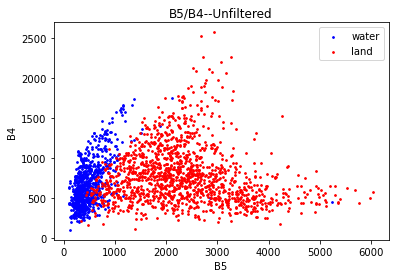

In [18]:
# 样本总数
print(samples.size().getInfo())
# 全部样本
land_B3 = samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array('B5').getInfo()
land_B6 = samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array('B4').getInfo()
water_B3 = samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array('B5').getInfo()
water_B6 = samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array('B4').getInfo()

land_B3 = np.array(land_B3)
land_B6 = np.array(land_B6)
water_B3 = np.array(water_B3)
water_B6 = np.array(water_B6)

plt.figure()
plt.scatter(water_B3,water_B6,s=3,c='blue', label = 'water')
plt.scatter(land_B3,land_B6,s=3,c='red', label = 'land')
plt.xlabel('B5')    
plt.ylabel('B4')
plt.title('B5/B4--Unfiltered') 
plt.legend()
plt.show()

2154


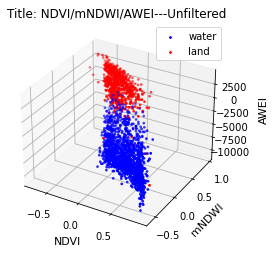

In [21]:
## 数据
# 样本总数
print(samples.size().getInfo())
# 全部样本
land_ndvi = samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array('NDVI').getInfo()
land_mndwi = samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array('mNDWI').getInfo()
land_awei = samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array('AWEI').getInfo()
water_ndvi = samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array('NDVI').getInfo()
water_mndwi = samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array('mNDWI').getInfo()
water_awei = samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array('AWEI').getInfo()

land_ndvi = np.array(land_ndvi)
land_mndwi = np.array(land_mndwi)
land_awei = np.array(land_awei)
water_ndvi = np.array(water_ndvi)
water_mndwi = np.array(water_mndwi)
water_awei = np.array(water_awei)

# 创建一个三维的绘图工程
ax = plt.subplot(111, projection='3d')  
# 绘制数据点
ax.scatter(land_ndvi, land_mndwi, land_awei, s=3,c='blue', label = 'water')  
ax.scatter(water_ndvi, water_mndwi, water_awei, s=3,c='red', label = 'land')
# 坐标轴
ax.set_xlabel('NDVI',fontsize = 11)
ax.set_ylabel('mNDWI',fontsize = 11)
ax.set_zlabel('AWEI',labelpad = 10,rotation=90,fontsize = 11)
plt.yticks([-0.5,0,0.5,1.0])
plt.title('Title: NDVI/mNDWI/AWEI---Unfiltered') 
plt.legend(loc='upper right')
plt.show()

# 筛选后的样本

1990


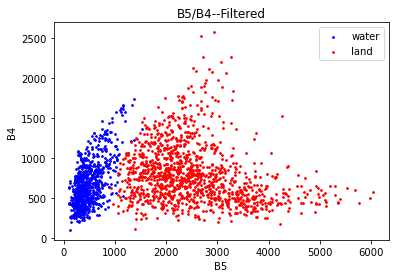

In [19]:
# 样本总数
filtered_sample = ee.FeatureCollection(filtered_sample)
print(filtered_sample.size().getInfo())
# 全部样本
land_B3 = filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array('B5').getInfo()
land_B6 = filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array('B4').getInfo()
water_B3 = filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array('B5').getInfo()
water_B6 = filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array('B4').getInfo()

land_B3 = np.array(land_B3)
land_B6 = np.array(land_B6)
water_B3 = np.array(water_B3)
water_B6 = np.array(water_B6)

plt.figure()
plt.scatter(water_B3,water_B6,s=3,c='blue', label = 'water')
plt.scatter(land_B3,land_B6,s=3,c='red', label = 'land')
plt.xlabel('B5')    
plt.ylabel('B4')
plt.title('B5/B4--Filtered') 
plt.legend()
plt.show()

1990


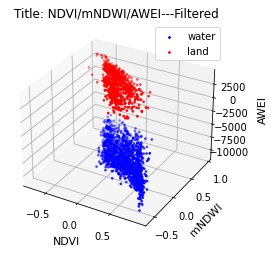

In [20]:
from mpl_toolkits.mplot3d import Axes3D

## 数据
# 样本总数
filtered_sample = ee.FeatureCollection(filtered_sample)
print(filtered_sample.size().getInfo())
# 全部样本
land_ndvi = filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array('NDVI').getInfo()
land_mndwi = filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array('mNDWI').getInfo()
land_awei = filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array('AWEI').getInfo()
water_ndvi = filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array('NDVI').getInfo()
water_mndwi = filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array('mNDWI').getInfo()
water_awei = filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array('AWEI').getInfo()

land_ndvi = np.array(land_ndvi)
land_mndwi = np.array(land_mndwi)
land_awei = np.array(land_awei)
water_ndvi = np.array(water_ndvi)
water_mndwi = np.array(water_mndwi)
water_awei = np.array(water_awei)

# 创建一个三维的绘图工程
ax = plt.subplot(111, projection='3d')  
# 绘制数据点
ax.scatter(land_ndvi, land_mndwi, land_awei, s=3,c='blue', label = 'water')  
ax.scatter(water_ndvi, water_mndwi, water_awei, s=3,c='red', label = 'land')
# 坐标轴
ax.set_xlabel('NDVI',fontsize = 11)
ax.set_ylabel('mNDWI',fontsize = 11)
ax.set_zlabel('AWEI',labelpad = 10,rotation=90,fontsize = 11)
plt.yticks([-0.5,0,0.5,1.0])
plt.title('Title: NDVI/mNDWI/AWEI---Filtered') 
plt.legend(loc='upper right')
plt.show()

# 附录

In [ ]:
## 未经过K_mean聚类
# RandomForest预测使用的波段
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','mNDWI','AWEI']
# 分类标签
label = 'waterclass'
# RF训练
trainedClassifier = ee.Classifier.smileRandomForest(20).train(samples,label,bands)

train_accuracy = trainedClassifier.confusionMatrix()
print(train_accuracy.getInfo())
print(train_accuracy.accuracy().getInfo())
print(train_accuracy.kappa().getInfo())

In [ ]:
## 经过K_mean聚类
# RandomForest预测使用的波段
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','mNDWI','AWEI']
# 分类标签
label = 'waterclass'
# RF训练
trainedClassifier = ee.Classifier.smileRandomForest(20).train(filtered_sample,label,bands)

train_accuracy = trainedClassifier.confusionMatrix()
print(train_accuracy.getInfo())
print(train_accuracy.accuracy().getInfo())
print(train_accuracy.kappa().getInfo())

In [ ]:
## 样本聚类（K_mean），代码重点内容
# “samples”为样本集
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI','mNDWI', 'AWEI']
clusterer = ee.Clusterer.wekaKMeans(2).train(samples,bands)
result = samples.cluster(clusterer)

# cluster与waterclass的对比
def Compare(feature):
    cluster = ee.Number(feature.get('cluster'))
    waterclass = ee.Number(feature.get('waterclass'))
    ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
    return ft

# 下面二选一
right = result.map(Compare).filter(ee.Filter.eq('eq',0))
error = result.map(Compare).filter(ee.Filter.eq('eq',1))
# 过滤后的样本
filtered_sample = ee.Algorithms.If(right.size().gt(error.size()),right,error)

# RandomForest预测使用的波段
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','mNDWI','AWEI']
# 分类标签
label = 'waterclass'
# RF训练
trainedClassifier = ee.Classifier.smileRandomForest(20).train(filtered_sample,label,bands)

In [ ]:
# k_means聚类
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI','mNDWI', 'AWEI']
# Generic Function to remove a property from a feature
def removeProperty(feat):
    selectProperties = ee.Feature(feat).propertyNames().filter(ee.Filter.neq('item', 'waterclass'))
    return feat.select(selectProperties)
samples = ee.FeatureCollection('users/311605001111/WuhanTrainingPoints_2020')
a = samples.first()
print(a.getInfo())
print(removeProperty(ee.Feature(a)).getInfo())
